# Stage 1 AI training: Input channels

This stage focuses on the **magnetic components** used as input for the machine learning models. Different architectures and rotational frames will be used for every magnetic component option.

In [1]:
# Import packages:
import MLQDM.MLmodel as ML_MLmodel
import MLQDM.timewindows as ML_twdw
import tensorflow as tf

# Check available GPU:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-10-26 13:26:17.695029: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-26 13:26:17.718532: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 13:26:17.718553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 13:26:17.719184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 13:26:17.723233: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1


2024-10-26 13:26:18.581014: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-26 13:26:18.602423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-26 13:26:18.602548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Load original data and general parameters
Load data from files (many segments) and store information in dataframes, one for each segment. The original data is in the **Laboratory rotational frame (RF1)**.

There are two possible sets of target labels, coming for the 'linear approximation' of 'physical model' approaches regarding the interpolated positions. You must choose one as {interp} for the training stage:
* **'lin_approx'** : linear approximation.
* **'phys_model'** : physical model based on acceleration profile.

In [2]:
# Choose Z-position interpolation method:
interp = 'phys_model' # 'phys_model' or 'lin_approx'

# Prepare files information:
data_path =  'Data/Final_t_BxByBz_zAut_LabFrame/' # Datafiles path
gen_pars_path = 'ML_parameters/'

# Load data, general hyperparameters and rotational frames:
data, hypers, RFs = ML_MLmodel.load_data_and_gen_pars(
    data_path,gen_pars_path,interp=interp,final_stage=False)

## Generate time windows

### Load original data

Each data segment is processed into time windows with a fixed time length (or equivalently, fixed number of points). The distribution of training and testing datasets is chosen here. The validation dataset is included within the training dataset.

Summary for time windows within training and testing datasets:

Number of points for every time window: 20
Time resolution: 0.1000 s

 --------------------  Training dataset  -------------------- 

time_0.0_to_59.53min: 35719 points, 59 min
time_60.02_to_239.35min: 107601 points, 179 min
time_600.13_to_717.73min: 70561 points, 117 min
Total points/time: 213881 / 5.94 hours

 --------------------  Testing dataset  -------------------- 

time_240.69_to_419.25min: 107138 points, 178 min
time_420.02_to_595.81min: 105475 points, 175 min
Total points/time: 212613 / 5.91 hours


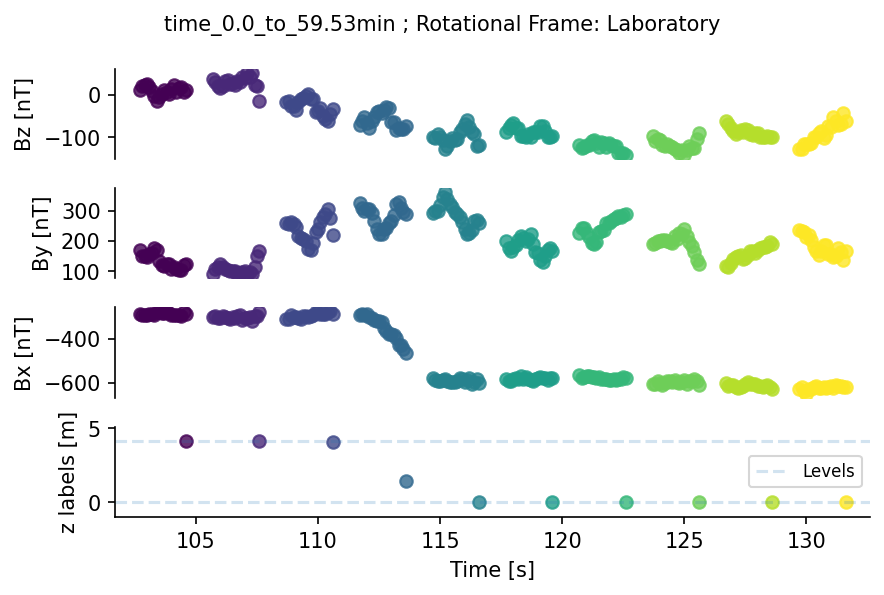

In [3]:
# Prepare time windows:
wdw_pp = 20
train_segm = [0,1,2]
t_wdws_train, t_wdws_test = ML_twdw.prepare_time_windows(
    data,wdw_pp,train_segm=train_segm,
    plot_instances=True,instances=10,start_wdw=1025,stride_pp=30)

### Machine Learning training

In this stage, each **[input magnetic components]** option will be combined with two architecture options:

1. A single Convolutional Neural Network (CNN) with 32 filters and kernel size 5 + Flattening layer + Two consecutive Dense Neural Network (DNN) with 512 neurons each.
2. Three consecutive DNN with 1024, 512, 512 neurons, respectively.

In both cases, the last output layer is a DNN with a single neuron and linear activation, which predicts a single value for the elevator Z-position, units [m], representing the position at the end of the time window.

The general hyperparameters for all ML models are defined according to the 'ML_gen_pars_S1to6.json' file. In addition, the following hyperparameters are also common to all ML models:

* "Time_Window_pp": {wdw_pp},
* "Dropout_Fraction": 0.
* "Activation_Function": 'relu'.
* "Optimizer": 'adam'.
* "Learning_Rate": 0.005.

In this stage, the standard rotational frames (RF1,RF2,RF3), described in the 'ML_RF_S1to6.json' file, are used to train and evaluate each ML model.

In [13]:
# Define additional hyperparameters:
extra_hypers = {
    "Time_Window_pp": wdw_pp,
    "Dropout_Fraction": 0,
    "Activation_Function": 'relu',
    "Optimizer": 'adam',
    "Learning_Rate": 0.005
}

# Define the two architecture options:
arch1 = {
    "Convolutional_Network": True,
    "Conv_Layers": [[32,5]],
    "Pool_Layers": [None],
    "Flatten_Average": True,
    "Dens_Layers": [512,512],
    "Model_Name": "S1_C5_D512_D512"
}
arch2 = {
    "Convolutional_Network": False,
    "Dens_Layers": [1024,512,512],
    "Model_Name": "S1_D1024_D512_D512"
}

# Combine all hyperparameters information and architecture options:
arch_opts = [dict(list(hypers.items())+list(extra_hypers.items())+list(arch.items()))\
             for arch in [arch1,arch2]]

# Prepare rotational frame options:
RF_opts = list(RFs.values())

Define input magnetic component options:

In [14]:
# Options for magnetic components:
B_comps_opts = [
    ['Bx'],['By'],['Bz'],['B'], # One component (scalar option included)
    ['Bx','By'],['Bx','Bz'], ['By','Bz'], # Two components
    ['Bx','By','Bz'] # Three components (full vector magnetometer)
    ]

Train and evaluate each architecture option in each available rotational frame for this stage and save the results in a .csv file (but not the models): 

In [16]:
# Prepare file path to export results:
results_path = f'Results_{interp}/Train_s1s2s3_Test_s4s5/'
# Prepare file path to check on already trained models and avoid repetitions:
check_rep_model = f'Results_{interp}/Train_s1s2s3_Test_s4s5/Stage1_{interp}_all_Train_s1s2s3_Test_s4s5.csv'

# Train all models:
df_results = ML_MLmodel.train_stage1(
    B_comps_opts,arch_opts,RF_opts,t_wdws_train,t_wdws_test,
    results_path=results_path,check_rep_model=check_rep_model,
    quick_timing_test=False
)